In [1]:
import pandas as pd
import datetime
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, cross_val_score, StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from functools import partial
import itertools
from sklift.models import ClassTransformation
import lightgbm as lgbm
import ipywidgets as widgets
import inspect
from datetime import timedelta
from sklearn import preprocessing
import gc
import scipy.stats as st 

In [2]:
import logging

# create logger
logger = logging.getLogger('lg')
logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

In [3]:
logger.info('info message')

2020-01-31 21:48:47,686 - lg - INFO - info message


# Utils

In [4]:
BASE_TRANSACTION_TEMPLATE = 'base_transaction'
FAVORITES_TEMPLATE = 'favorites'
STEPS_MAPPING = {
    'BASE': (False, 'base_features.csv'),
    'BASE_TRANSACTION': (False, BASE_TRANSACTION_TEMPLATE),
    'FAVORITES': (False, FAVORITES_TEMPLATE),
    'POPULARITY': (False, 'popularity'),
    'ALCO': (True, 'alco'),
    'TIME': (True, 'trans_time'),
}

In [5]:
def generate_file_name(prefix, offset):
    return '{}_{}.csv'.format(prefix, str(offset))

In [6]:
def get_features_from_files(offsets):
    features = pd.read_csv(STEPS_MAPPING['BASE'][1], index_col='client_id')
    
    base_trans_array = []
    for offset in offsets:
        offset = offset or ''
        base_trans_array.append(pd.read_csv(generate_file_name(STEPS_MAPPING['BASE_TRANSACTION'][1], offset), 
                                 index_col='client_id'))
    
    for df in base_trans_array:
        features = features.merge(df, left_index=True, right_index=True)
        del df

    gc.collect()
    favorites_array = []
    for offset in offsets:
        offset = offset or ''
        favorites_array.append(pd.read_csv(generate_file_name(STEPS_MAPPING['FAVORITES'][1], offset), 
                                           index_col='client_id'))
    
    for df in favorites_array:
        features = features.merge(df, left_index=True, right_index=True)
        del df
    gc.collect()

    popularity_array = []
    for offset in offsets:
        offset = offset or ''
        popularity_array.append(pd.read_csv(generate_file_name(STEPS_MAPPING['POPULARITY'][1], offset), 
                                           index_col='client_id'))
    
    for df in popularity_array:
        features = features.merge(df, left_index=True, right_index=True)
        del df
    gc.collect()

    alc = pd.read_csv(generate_file_name(STEPS_MAPPING['ALCO'][1], None), index_col='client_id')
    features = features.merge(alc, left_index=True, right_index=True)

    trans_time = pd.read_csv(generate_file_name(STEPS_MAPPING['TIME'][1], None), index_col='client_id')
    features = features.merge(trans_time, left_index=True, right_index=True)

    return features

In [7]:
def uplift_score(prediction, treatment, target, rate=0.3):
    """
    Подсчет Uplift Score
    """
    order = np.argsort(-prediction)

    treatment_n = int((treatment == 1).sum() * rate)
    treatment_p = target[order][treatment[order] == 1][:treatment_n].mean()

    control_n = int((treatment == 0).sum() * rate)
    control_p = target[order][treatment[order] == 0][:control_n].mean()

    score = treatment_p - control_p
    return score


def get_train_test(features, df_train, df_test):
    return features.loc[df_train.index, :], features.loc[df_test.index, :]

In [8]:
def balance_learn(X_learn, y_learn):
    _, treatment_counts = np.unique(y_learn.treatment_flg, return_counts=True)
    logger.info("{}, {}, {}".format(X_learn.shape, y_learn.shape, treatment_counts[0] - treatment_counts[1]))
    
    treat_learn = y_learn.treatment_flg
    vc = treat_learn.value_counts()
    treat_learn = pd.concat([treat_learn[treat_learn == i].sample(vc.min()) for i in vc.index])

    X_learn = X_learn.loc[treat_learn.index, :]
    y_learn = y_learn.loc[treat_learn.index, :]
    
    _, treatment_counts = np.unique(y_learn.treatment_flg, return_counts=True)
    logger.info("{}, {}, {}".format(X_learn.shape, y_learn.shape, treatment_counts[0] - treatment_counts[1]))
    return X_learn, y_learn

In [9]:
def uplift_score_func(y_true, y_pred, **kwargs):
    return uplift_score(y_pred, treatment=y_true.treatment_flg, target=y_true.target)

In [10]:
class MyClassTransformation(ClassTransformation):
    def fit(self, X, y, estimator_fit_params=None):
        return  super().fit(X, y=y.target, treatment=y.treatment_flg, estimator_fit_params=estimator_fit_params)

In [11]:
def merge_transactions_and_products(products, transactions):
    columns = ['brand_id', 'vendor_id', 'segment_id', 'product_id']
    transactions_with_products = transactions.merge(products, left_on='product_id', right_index=True)
    logger.info('transactions_with_products')
    for col in columns:
        fg = transactions_with_products.drop_duplicates(subset=['client_id', col]) \
                                       .groupby([col]).size().sort_values(ascending=False)
        fg.name = 'popularity_{}'.format(col)
        
        if col == 'product_id':
            products = products.merge(fg, left_index=True, right_index=True)
        else:
            products = products.join(fg, on=col)
        logger.info('popularity {}'.format(col))
    new_columns = ['popularity_{}'.format(col) for col in columns]
    transactions_with_products = transactions_with_products.merge(products[new_columns], left_on='product_id', right_index=True)
    return transactions_with_products

In [12]:
def get_transactions(df_purchases, offset=None):
    if not offset:
        return df_purchases

    last_date = df_purchases.date.max()    
    sub_df_purchases = df_purchases[df_purchases.date > last_date-timedelta(days=offset)]
    logger.info("sub_df_purchases shape : {}".format(sub_df_purchases.shape))
    return sub_df_purchases

# Чтение данных

In [13]:
def get_products_features(trans):
    columns = ['brand_id', 'vendor_id', 'segment_id', 'product_id']
    columns2 = ['popularity_{}'.format(col) for col in columns]
    total_pop = trans.groupby('client_id')[columns2].sum()
    logger.info(total_pop.columns[0])
    yield total_pop
    
    avg_trans_pop = trans.groupby(['client_id', 'transaction_id'])[columns2].sum().groupby(['client_id'])[columns2].mean()
    avg_trans_pop.columns = ['avg_trans_{}'.format(c) for c in avg_trans_pop.columns]
    logger.info(avg_trans_pop.columns[0])
    yield avg_trans_pop

    total_unique = trans.groupby(['client_id'])[columns].nunique()
    total_unique.columns = ['total_unique_{}'.format(c) for c in total_unique.columns]
    logger.info(total_unique.columns[0])
    yield total_unique

    avg_trans_unique = trans.groupby(['client_id', 'transaction_id'])[columns].nunique().groupby(['client_id'])[columns].mean()
    avg_trans_unique.columns = ['avg_trans_unique_{}'.format(c) for c in avg_trans_unique.columns]
    logger.info(avg_trans_unique.columns[0])
    yield avg_trans_unique
    
    result = []
    for c in columns[:-1]:
        fc = trans.groupby(['client_id', c])['product_id'].nunique().groupby(['client_id']).mean()
        fc.name = 'avg_nunique_prod_in_{}'.format(c)
        result.append(fc)
    avg_nunique_prod = pd.concat(result, axis=1, sort=False)
    logger.info(avg_nunique_prod.columns[0])
    yield avg_nunique_prod

In [14]:
def pop_features(offset):
    offset = offset or ''
    final = None
    for df in get_products_features(df_purchases):    
        final = final.merge(df, left_index=True, right_index=True) if final is not None else df
    final.index.name = 'client_id'
    if STEPS_MAPPING['POPULARITY'][0]:
        final.to_csv(generate_file_name(STEPS_MAPPING['POPULARITY'][1], offset))
    return final

In [15]:
def base_features(clean=True):
    df_features = pd.read_csv('data/clients.csv', index_col='client_id', parse_dates=['first_issue_date','first_redeem_date'])
    df_features['gender'] = LabelEncoder().fit_transform(df_features.gender)
    df_features['first_issue_time'] = pd.to_datetime(df_features['first_issue_date']).astype(int) / 10 ** 9
    df_features['first_redeem_time'] = pd.to_datetime(df_features['first_redeem_date']).astype(int) / 10 ** 9
    df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']
    df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)
    if STEPS_MAPPING['BASE'][0]:
        df_features.to_csv(STEPS_MAPPING['BASE'][1])
    
    if clean:
        del df_features
        gc.collect()
        return

    return df_features

In [16]:
def transactions_features(transactions, offset=None, clean=True):
    offset = offset or ''
    last_cols = [
        'regular_points_received', 
        'express_points_received',
        'regular_points_spent',
        'express_points_spent',
        'purchase_sum'
    ]

    logger.info("Create history")
    history = transactions.groupby(['client_id', 'transaction_id'])[last_cols].last()
    
    logger.info("Create _features")
    _features = [
        (history.groupby('client_id')['purchase_sum'].count(), ['total_trans_count']), 
        (history.groupby('client_id').sum(), last_cols)
    ]
    
    _features = list(zip(*_features))
    transactions_features =  pd.concat(_features[0], axis = 1)
    transactions_features.columns = list(itertools.chain.from_iterable(_features[1]))
    transactions_features.columns = ['days_{}_'.format(str(offset)) + c for c in transactions_features.columns]
    if STEPS_MAPPING['BASE_TRANSACTION'][0]:
        transactions_features.to_csv(generate_file_name(STEPS_MAPPING['BASE_TRANSACTION'][1], offset))
    
    if clean:
        del transactions_features
        gc.collect()
        return

    
    return transactions_features

In [17]:
def favorite_products_features(merged_transactions, offset=None, clean=True):

    offset = offset or ''
    # вычисляем любимый продукт/категорию/сегмент для каждого юзера.
    cols = ['product_id', 'brand_id', 'vendor_id', 'segment_id']
    result = []
    for c in cols:
        logger.info("favorite {}".format(c))
        result.append(
            merged_transactions.groupby(['client_id', c]).size().reset_index(name='counts').groupby(['client_id']).max()[c]
        )

    favorites = pd.concat(result, axis=1, sort=False)
    favorites.columns = [str(offset) + '_faivorite_' + c for c in cols]
    favorites.index.name = 'client_id'

    for col in favorites.columns:
        logger.info('LabelEncoder for {}'.format(col))
        favorites[col] = LabelEncoder().fit_transform(favorites[col].astype(str))    

    if STEPS_MAPPING['FAVORITES'][0]:
        favorites.to_csv(generate_file_name(STEPS_MAPPING['FAVORITES'][1], offset))

    if clean:
        del favorites
        gc.collect()
        return        
        
    return favorites

In [18]:
def generate_the_first_part_of_features(offset, df_products, df_purchases):
    sb_df_purchases = get_transactions(df_purchases, offset=offset)
    transactions_features(sb_df_purchases, offset=offset)
    sb_df_purchases = merge_transactions_and_products(df_products, sb_df_purchases)
    favorite_products_features(merged_transactions=sb_df_purchases, offset=offset)

In [19]:
def prepare_data_for_alcohol_and_trade_mark(df_products, df_purchases):
    return df_purchases[[
        "client_id", 
        "product_id"
    ]].merge(
        df_products[["is_own_trademark","is_alcohol"]], 
        left_on='product_id', right_index=True)

In [20]:
def agg_alvo_features(alk_dt, columns):
    tmp = alk_dt.groupby(columns).agg({
    'product_id' : 'count', 
    'is_alcohol' : 'sum', 
    'is_own_trademark' : 'sum'})
    tmp['part_own_trademark'] = tmp.is_own_trademark / tmp.product_id
    tmp['part_is_alcohol'] = tmp.is_alcohol / tmp.product_id
    
    return_columns = ['is_own_trademark', 'part_own_trademark', 'is_alcohol', 'part_is_alcohol']
    if len(columns) > 1:
        result = tmp.groupby(columns[:1:]).mean()[return_columns]
        result.columns = ['trans_avg_{}'.format(c) for c in return_columns]
    else:
        result = tmp[return_columns]
    
    return  result

In [21]:
def prepare_alco_features():
    alco_data = prepare_data_for_alcohol_and_trade_mark(df_products, df_purchases)
    avg_trans_features = agg_alvo_features(alco_data, ['client_id', 'transaction_id'])
    history_features = agg_alvo_features(alco_data, ['client_id'])
    alco_features = avg_trans_features.merge(history_features, left_index=True, right_index=True)
    if STEPS_MAPPING['ALCO'][0]:
        alco_features.to_csv(generate_file_name(STEPS_MAPPING['ALCO'][1], None))
    return alco_features

In [22]:
def prepare_timeseries_features(df_purchases):
    df_purchases = df_purchases[['client_id', 'date']].drop_duplicates().sort_values(['client_id', 'date'])
    df_purchases['Time Delta'] = np.where(
        df_purchases['client_id'] == df_purchases['client_id'].shift(), 
        df_purchases['date'] - df_purchases['date'].shift(1), np.nan)
    df_purchases['td_ints'] = df_purchases['Time Delta'].apply(lambda x: x.days)
    
    max_date = df_purchases.date.max()
    avg_trans_diff = df_purchases.groupby(['client_id'])['td_ints'].mean()
    max_trans_diff = df_purchases.groupby(['client_id'])['td_ints'].max()
    min_trans_diff = df_purchases.groupby(['client_id'])['td_ints'].min()
    max_user_date = max_date - df_purchases.groupby(['client_id'])['date'].max()
    min_user_date = max_date - df_purchases.groupby(['client_id'])['date'].min()
    user_diff = min_user_date - max_user_date 
    res = pd.concat([
        avg_trans_diff,
        max_trans_diff,
        min_trans_diff,
        max_user_date,
        min_user_date,
        user_diff], axis = 1)
    res.columns = [
        'avg_trans_diff',
        'max_trans_diff',
        'min_trans_diff',
        'max_user_date',
        'min_user_date',
        'user_diff']
    for c in ['max_user_date', 'min_user_date', 'user_diff']:
        res[c] = res[c].apply(lambda x: x.days)
        
    if STEPS_MAPPING['TIME'][0]:
        res.to_csv(generate_file_name(STEPS_MAPPING['TIME'][1], None))    

In [23]:
# df_products = pd.read_csv('data/products.csv', index_col='product_id')
# logger.info("df_products shape {}".format(df_products.shape))

#df_purchases = pd.read_csv('data/purchases.csv', index_col='transaction_id', parse_dates=['transaction_datetime'], nrows=100000)
# df_purchases = pd.read_csv('data/purchases.csv', index_col='transaction_id', parse_dates=['transaction_datetime'])
# df_purchases['date'] = df_purchases['transaction_datetime'].dt.date
# logger.info("df_purchases shape {}".format(df_purchases.shape))

In [24]:
# prepare_timeseries_features(df_purchases)

In [25]:
# base_features(df_clients);

In [26]:
# offets = [None]
# for offst in offets:
#     logger.info('{} offst = {}'.format('--'*30, offst))
#     generate_the_first_part_of_features(offst, df_products, df_purchases);

In [27]:
# offset = 14
# df_purchases = merge_transactions_and_products(df_products, get_transactions(df_purchases, offset=offset))
# tpf = pop_features(offset)

In [28]:
# q = prepare_alco_features()

In [29]:
# q.shape

In [30]:
offets = [14, 30, None]
features = get_features_from_files(offets)

In [31]:
features.head()

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay,days_14_total_trans_count,days_14_regular_points_received,days_14_express_points_received,days_14_regular_points_spent,days_14_express_points_spent,...,is_own_trademark,part_own_trademark,is_alcohol,part_is_alcohol,avg_trans_diff,max_trans_diff,min_trans_diff,max_user_date,min_user_date,user_diff
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,45,2,1.501948e+09,1.515094e+09,1.314656e+07,2,10.0,0.0,0.0,0.0,...,4,0.076923,0,0.000000,34.333333,82.0,6.0,4,107,103
000036f903,72,0,1.491832e+09,1.492951e+09,1.118613e+06,3,4.1,0.0,0.0,0.0,...,14,0.086420,1,0.006173,3.516129,13.0,1.0,1,110,109
000048b7a6,68,0,1.544881e+09,-9.223372e+09,-1.076825e+10,1,1.2,0.0,0.0,0.0,...,3,0.053571,0,0.000000,12.428571,26.0,3.0,6,93,87
000073194a,60,0,1.495544e+09,1.511522e+09,1.597811e+07,1,1.3,0.0,0.0,0.0,...,3,0.036585,9,0.109756,6.937500,22.0,1.0,2,113,111
00007f9014,45,0,1.503409e+09,1.550258e+09,4.684946e+07,2,3.3,0.0,0.0,0.0,...,4,0.036036,0,0.000000,4.480000,19.0,1.0,3,115,112


In [32]:
features.shape

(346831, 106)

In [33]:
df_train = pd.read_csv('data/uplift_train.csv', index_col='client_id')
logger.info(df_train.shape)

df_test = pd.read_csv('data/uplift_test.csv', index_col='client_id')
logger.info(df_test.shape)

2020-01-31 21:48:59,372 - lg - INFO - (200039, 2)
2020-01-31 21:48:59,475 - lg - INFO - (200123, 0)


In [34]:
x_train, x_test = get_train_test(features, df_train, df_test)

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [35]:
x_train.head()

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay,days_14_total_trans_count,days_14_regular_points_received,days_14_express_points_received,days_14_regular_points_spent,days_14_express_points_spent,...,is_own_trademark,part_own_trademark,is_alcohol,part_is_alcohol,avg_trans_diff,max_trans_diff,min_trans_diff,max_user_date,min_user_date,user_diff
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,45.0,2.0,1.501948e+09,1.515094e+09,13146559.0,2.0,10.0,0.0,0.0,0.0,...,4.0,0.076923,0.0,0.000000,34.333333,82.0,6.0,4.0,107.0,103.0
000036f903,72.0,0.0,1.491832e+09,1.492951e+09,1118613.0,3.0,4.1,0.0,0.0,0.0,...,14.0,0.086420,1.0,0.006173,3.516129,13.0,1.0,1.0,110.0,109.0
00010925a5,83.0,2.0,1.532449e+09,1.536942e+09,4492280.0,4.0,5.8,0.0,0.0,0.0,...,9.0,0.115385,1.0,0.012821,6.437500,34.0,1.0,10.0,113.0,103.0
0001f552b0,33.0,0.0,1.498850e+09,1.535461e+09,36610747.0,4.0,44.7,0.0,0.0,0.0,...,10.0,0.116279,0.0,0.000000,9.333333,26.0,1.0,2.0,114.0,112.0
00020e7b18,73.0,2.0,1.511783e+09,1.515607e+09,3823700.0,2.0,15.6,0.0,-58.0,-10.0,...,44.0,0.161765,0.0,0.000000,7.466667,19.0,1.0,3.0,115.0,112.0


In [36]:
indices_learn, indices_valid = train_test_split(x_train.index, test_size=0.3)

In [37]:
X_learn = x_train.loc[indices_learn, :]
y_learn = df_train.loc[indices_learn, :]

X_val = x_train.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, :]

In [38]:
params = {'learning_rate':0.01,'max_depth':4,'num_leaves':20,
             'min_data_in_leaf':3, 'application':'binary', 'subsample':0.8, 'colsample_bytree': 0.8,
             'reg_alpha':0.01,'data_random_seed':1, 'metric':'binary_logloss',
             'max_bin':416,'bagging_freq':3,'reg_lambda':0.01, 'class_weight': 'balanced',             
    }

In [39]:
matrix = lgbm.Dataset(X_learn, label=y_learn.target)
cv_result = lgbm.cv(params, matrix, num_boost_round=2000,nfold=5, stratified=True, 
                    shuffle=True, early_stopping_rounds=50, verbose_eval=50)

[50]	cv_agg's binary_logloss: 0.599527 + 0.000644838
[100]	cv_agg's binary_logloss: 0.571442 + 0.00102961
[150]	cv_agg's binary_logloss: 0.55847 + 0.00132436
[200]	cv_agg's binary_logloss: 0.552205 + 0.00153926
[250]	cv_agg's binary_logloss: 0.548753 + 0.00159086
[300]	cv_agg's binary_logloss: 0.546552 + 0.00167136
[350]	cv_agg's binary_logloss: 0.544817 + 0.00172555
[400]	cv_agg's binary_logloss: 0.543692 + 0.00177208
[450]	cv_agg's binary_logloss: 0.542914 + 0.00185996
[500]	cv_agg's binary_logloss: 0.542282 + 0.00194882
[550]	cv_agg's binary_logloss: 0.541802 + 0.00197977
[600]	cv_agg's binary_logloss: 0.541472 + 0.00197821
[650]	cv_agg's binary_logloss: 0.541236 + 0.00197699
[700]	cv_agg's binary_logloss: 0.540985 + 0.00197658
[750]	cv_agg's binary_logloss: 0.540873 + 0.00198076
[800]	cv_agg's binary_logloss: 0.540719 + 0.00195731
[850]	cv_agg's binary_logloss: 0.540586 + 0.00201795
[900]	cv_agg's binary_logloss: 0.54055 + 0.00203869
[950]	cv_agg's binary_logloss: 0.540486 + 0.0020

In [40]:
len(cv_result['binary_logloss-mean'])

1305

In [41]:
params['n_estimators'] = len(cv_result['binary_logloss-mean'])

In [42]:
from sklearn.metrics import make_scorer
parameters = {
    'classifier__estimator__max_depth': [3, 4],
    'classifier__estimator__num_leaves': list(range(20, 50, 15)),
    'classifier__estimator__min_child_samples': list(range(20, 50, 15)),
#     'classifier__estimator__class_weight': ['balanced', None]

}
modelcv = GridSearchCV(
    Pipeline(steps=[
        ('classifier', MyClassTransformation(lgbm.LGBMClassifier(**params)))
    ]),
    parameters,
    scoring=make_scorer(uplift_score_func), 
    cv=ShuffleSplit(n_splits=4, test_size=0.3, random_state=12), 
    verbose=3, n_jobs=-1
)
modelcv.fit(X_learn, y_learn);

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 10.5min finished
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  app.launch_new_instance()


In [43]:
modelcv.best_estimator_

Pipeline(memory=None,
         steps=[('classifier',
                 MyClassTransformation(estimator=LGBMClassifier(application='binary',
                                                                bagging_freq=3,
                                                                boosting_type='gbdt',
                                                                class_weight='balanced',
                                                                colsample_bytree=0.8,
                                                                data_random_seed=1,
                                                                importance_type='split',
                                                                learning_rate=0.01,
                                                                max_bin=416,
                                                                max_depth=3,
                                                                metric='binary_logloss',
                    

In [44]:
modelcv.best_score_

0.06672195372906808

In [45]:
final_model = modelcv.best_estimator_

In [46]:
print('Validation score:', uplift_score(final_model.predict(X_val), treatment=y_val.treatment_flg, target=y_val.target))

Validation score: 0.08942865324702898


# Подготовка предсказаний для тестовых клиентов

In [47]:
x_train, df_train = balance_learn(x_train, df_train)

2020-01-31 22:02:26,719 - lg - INFO - (200039, 106), (200039, 2), 77
2020-01-31 22:02:27,078 - lg - INFO - (199962, 106), (199962, 2), 0


In [48]:
final_model.fit(x_train, df_train)

Pipeline(memory=None,
         steps=[('classifier',
                 MyClassTransformation(estimator=LGBMClassifier(application='binary',
                                                                bagging_freq=3,
                                                                boosting_type='gbdt',
                                                                class_weight='balanced',
                                                                colsample_bytree=0.8,
                                                                data_random_seed=1,
                                                                importance_type='split',
                                                                learning_rate=0.01,
                                                                max_bin=416,
                                                                max_depth=3,
                                                                metric='binary_logloss',
                    

In [49]:
upl_sc = final_model.predict(x_test)
pd.DataFrame({'client_id':x_test.index.values,'uplift': upl_sc}).to_csv('final_score.csv')

In [50]:
fi = pd.DataFrame({
    'feature_score': final_model.steps[0][1].estimator.feature_importances_
}, index=x_train.columns).sort_values('feature_score')

In [51]:
%matplotlib inline

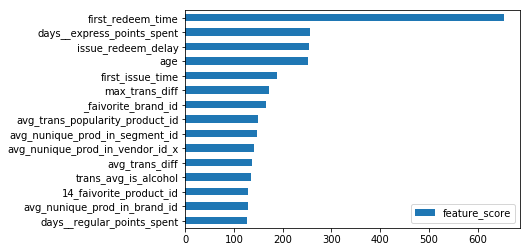

In [52]:
ax = fi.tail(15).plot.barh()

### вычислим доверительный интервал оценки прогноза, чтобы по Public отсеживать overfit 

In [53]:
scores = cross_val_score(
    final_model, x_train, df_train,
    cv=ShuffleSplit(n_splits=10, test_size=0.3), 
    scoring=make_scorer(uplift_score_func)
)
scores

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  app.launch_new_instance()


array([0.05739091, 0.05729365, 0.08219399, 0.06799848, 0.07849729,
       0.06154235, 0.0883591 , 0.07282524, 0.08662477, 0.05974196])

In [54]:
np.mean(scores), st.sem(scores)

(0.07124677396424418, 0.003841267173655085)

In [55]:
st.t.interval(0.95, len(scores)-1, loc=np.mean(scores), scale=st.sem(scores)) 

(0.0625572239133585, 0.07993632401512987)